# Лабораторна 6 

In [1]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score, accuracy_score
import seaborn as sns


## Завдання 1

#### Необхідно побудувати регресійну модель на одному з вбудованих датасетів, доступних у бібліотеці scikit-learn. Основна мета завдання — навчитися побудові регресійних моделей та уникненню перенавчання (overfitting) шляхом застосування відповідних технік.

##### 1. Завантаження та підготовка даних:  Виберіть вбудований датасет для задачі регресії з бібліотеки scikit-learn (наприклад, Boston Housing,  California Housing) або будь-який датасет для регресії.

<p>Обираєм California Housing Dataset.</p>

In [2]:
california = fetch_california_housing()
X = california.data
y = california.target

<p>Завантажте дані та розділіть їх на навчальну та тестову вибірки 
(рекомендується використовувати співвідношення 80/20 або 70/30).</p>

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<p>2. Побудова регресійної моделі:  Побудуйте базову лінійну регресійну модель на основі навчальної вибірки </p>

In [4]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

<p>Оцініть точність моделі на тестовій вибірці та визначте її продуктивність, 
використовуючи метрики якості регресії (наприклад, mean_squared_error, 
R^2). </p>

In [5]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [6]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

In [7]:
print(f"Базова модель (Лінійна регресія):")
print(f"Навчальні дані: MSE = {train_mse:.2f}, R^2 = {train_r2:.2f}")
print(f"Тестові дані: MSE = {test_mse:.2f}, R^2 = {test_r2:.2f}")

Базова модель (Лінійна регресія):
Навчальні дані: MSE = 0.52, R^2 = 0.61
Тестові дані: MSE = 0.56, R^2 = 0.58


<p></p>

<p>3. Аналіз перенавчання:  Перевірте наявність перенавчання, порівнюючи результати на навчальній та 
тестовій вибірках. Якщо модель показує значно кращі результати на 
навчальних даних, це може свідчити про перенавчання. </p>

<p>У цьому випадку різниця незначна, що говорить про хорошу узагальнюючу здатність моделі. Ознак суттєвого перенавчання у моделі немає.</p>

<p></p>

<p>4. Запобігання перенавчанню:  Введіть регуляризацію: використайте моделі з регуляризацією, такі як Ridg 
Regression або Lasso Regressio Перевірте роботу моделі з різними значеннями параметра регуляризації та 
виберіть оптимальне значення. </p>

In [8]:
alphas = np.logspace(0, 4, 100)

In [9]:
ridge_cv_scores = []
for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    scores = cross_val_score(ridge_model, X, y, cv=5, scoring='neg_mean_squared_error')
    ridge_cv_scores.append(-scores.mean())

In [10]:
lasso_cv_scores = []
for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train, y_train)
    scores = cross_val_score(lasso_model, X, y, cv=5, scoring='neg_mean_squared_error')
    lasso_cv_scores.append(-scores.mean())

In [11]:
best_ridge_alpha = alphas[np.argmin(ridge_cv_scores)]
best_lasso_alpha = alphas[np.argmin(lasso_cv_scores)]

print(f"Найкраще значення alpha для Ridge: {best_ridge_alpha}")
print(f"Найкраще значення alpha для Lasso: {best_lasso_alpha}")

Найкраще значення alpha для Ridge: 72.20809018385468
Найкраще значення alpha для Lasso: 1.0


<p>Прогнозуєм значення для тестової вибірки.</p>

In [12]:
ridge_model = Ridge(alpha=best_ridge_alpha)
ridge_model.fit(X_train, y_train)
ridge_y_test_pred = ridge_model.predict(X_test)

lasso_model = Lasso(alpha=best_lasso_alpha)
lasso_model.fit(X_train, y_train)
lasso_y_test_pred = lasso_model.predict(X_test)

In [13]:
ridge_test_mse = mean_squared_error(y_test, ridge_y_test_pred)
lasso_test_mse = mean_squared_error(y_test, lasso_y_test_pred)
ridge_test_r2 = r2_score(y_test, ridge_y_test_pred)
lasso_test_r2 = r2_score(y_test, lasso_y_test_pred)

print(f"Ridge Regression: MSE = {ridge_test_mse:.2f}, R^2 = {ridge_test_r2:.2f}")
print(f"Lasso Regression: MSE = {lasso_test_mse:.2f}, R^2 = {lasso_test_r2:.2f}")

Ridge Regression: MSE = 0.55, R^2 = 0.58
Lasso Regression: MSE = 0.94, R^2 = 0.28


<p>Застосуйте крос-валідацію для більш стабільної оцінки продуктивності 
моделі.</p>

In [14]:
def cross_validate_model(model, X, y, cv=5):
    mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    
    print(f"{model.__class__.__name__} Cross-Validation Results:")
    print(f"Mean MSE: {-np.mean(mse_scores):.4f} (+/- {np.std(mse_scores) * 2:.4f})")
    print(f"Mean R^2: {np.mean(r2_scores):.4f} (+/- {np.std(r2_scores) * 2:.4f})")
    print()
    
ridge_model = Ridge(alpha=best_ridge_alpha)
cross_validate_model(ridge_model, X, y)

lasso_model = Lasso(alpha=best_lasso_alpha)
cross_validate_model(lasso_model, X, y)

linear_model = LinearRegression()
cross_validate_model(linear_model, X, y)

Ridge Cross-Validation Results:
Mean MSE: 0.5579 (+/- 0.1359)
Mean R^2: 0.5534 (+/- 0.1256)

Lasso Cross-Validation Results:
Mean MSE: 1.0023 (+/- 0.2228)
Mean R^2: 0.2035 (+/- 0.1038)

LinearRegression Cross-Validation Results:
Mean MSE: 0.5583 (+/- 0.1312)
Mean R^2: 0.5530 (+/- 0.1234)



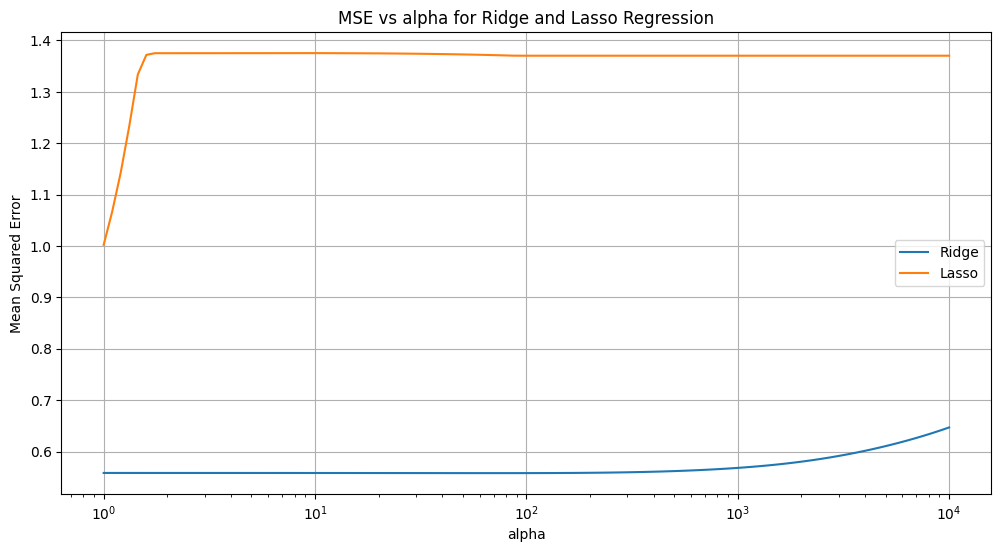

In [15]:
plt.figure(figsize=(12, 6))
plt.semilogx(alphas, ridge_cv_scores, label='Ridge')
plt.semilogx(alphas, lasso_cv_scores, label='Lasso')
plt.xlabel('alpha')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs alpha for Ridge and Lasso Regression')
plt.legend()
plt.grid(True)
plt.show()

### Висновки та рекомендації:
##### Ridge регуляризація не покращила модель, але й не погіршила її. Це може вказувати на те, що вихідні дані не мають сильної мультиколлінеарності.
##### Lasso регулювання значно погіршило модель.
##### Cлід переглянути параметри регуляризації для Lasso. Можливо, варто використати менші значення альфа.
##### Можна дослідити важливість ознак. Можливо, деякі ознаки можна видалити без регуляризації.

##### Базова лінійна регресія без регуляризації показала найкращі результати.

## Завдання 2

### Виконати кластерізацію даних. Затосувати метод ліктя або метод силуетів.

In [16]:
wcss_2d = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit(X_train)
    wcss_2d.append(kmeans.inertia_)

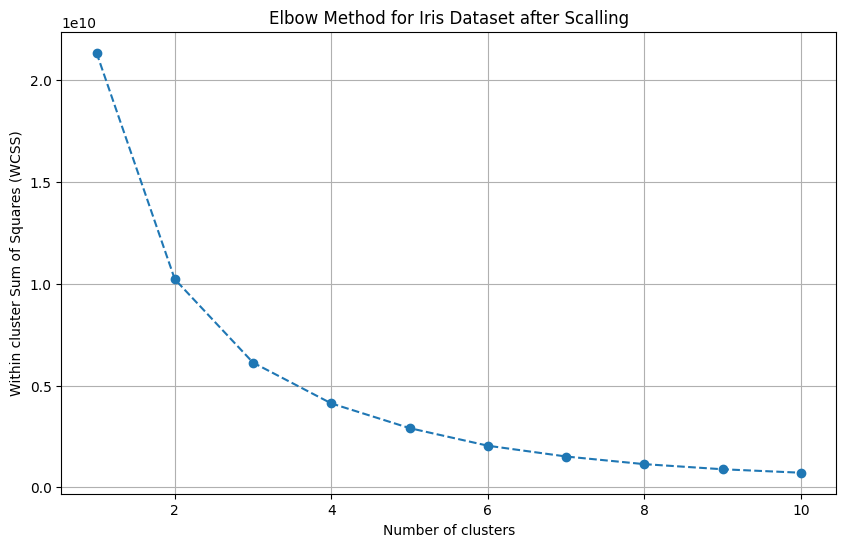

In [17]:
plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss_2d, marker='o', linestyle='--')
plt.title('Elbow Method for Iris Dataset after Scalling')
plt.xlabel('Number of clusters')
plt.ylabel('Within cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

In [18]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(X_train)
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    silhouette_scores.append(silhouette_avg)

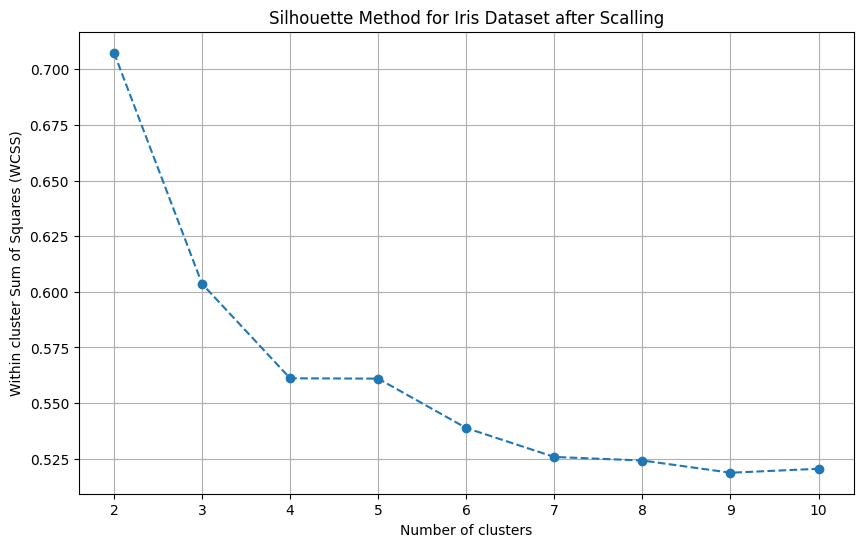

In [19]:
plt.figure(figsize=(10,6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Method for Iris Dataset after Scalling')
plt.xlabel('Number of clusters')
plt.ylabel('Within cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

<p>Обидва методи дають однаковий результат = 2.</p>

<p>Візуалізація кластерів.</p>

In [20]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_train)

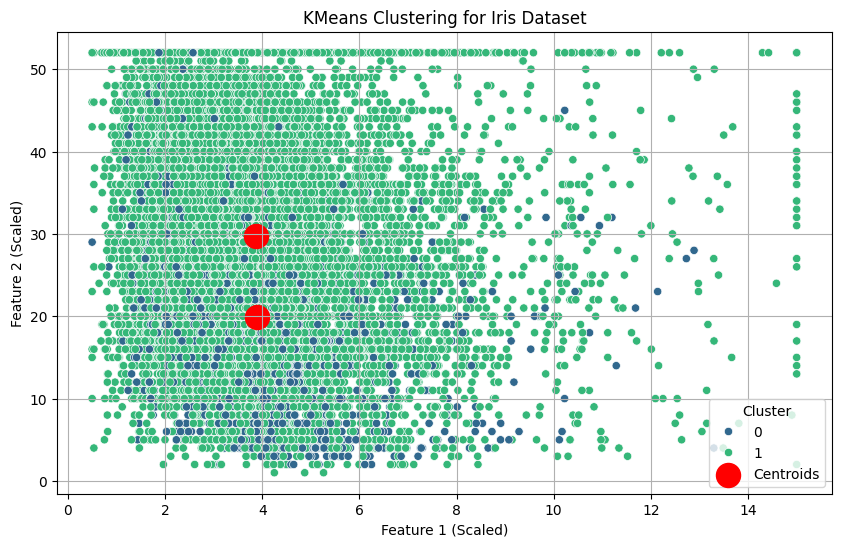

In [21]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=clusters, palette='viridis', legend='full')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.title('KMeans Clustering for Iris Dataset')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

### Висновки:

#### оптимальна к-сть кластерів для даної задачі = 2.
#### метод ліктя не дає чіткої відповіді, судячи по графіку, тому слід краще використати метод силуетів
